# Würzburg Weather Time Series Forecasting Analysis & Methods Comparasion
This section introduces the project and its goals.

## Introduction
In this notebook i will walk through time series forecasting by preprocessing the data, splitting into training and testing parts, than introducing the models, training each of them separately with the training dataset, evaluating the performance of models with  The data we will be using is hourly energy consumptio

In [177]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
#import xgboost as xgb
#from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data Exploration

In this section, we will explore the weather dataset for the city of Würzburg, which spans from January 1, 1979, to June 18, 2021. The dataset contains 19,179 rows and includes daily weather information over a period of more than four decades. 

### Dataset Description

The dataset consists of the following columns:

- **date**: The date of the weather observation.
- **temp_max**: The maximum temperature recorded on the given date.
- **temp_min**: The minimum temperature recorded on the given date.
- **temp_avg**: The average temperature on the given date.
- **rain**: The amount of rainfall (in mm) recorded on the given date.
- **snow**: The amount of snowfall (in mm) recorded on the given date.
- **weather_desc**: A textual description of the weather on the given date.

### Objective

The objective of this analysis is to perform time series forecasting using different models on this weather data. By analyzing and modeling the data, we aim to predict future weather patterns, which can be valuable for various applications such as agriculture, urban planning, and personal planning.

### Initial Data Inspection

To begin our exploration, we will:
- Load the dataset.
- Inspect the first few rows of the data to understand its structure.
- Check for any missing values and handle them appropriately.
- Generate summary statistics to get an overview of the dataset.
- Visualize the data to identify any trends, seasonality, and outliers.

This initial exploration will help us gain insights into the dataset and prepare it for further analysis and modeling.


In [178]:
# Read the datasetb
weather_würzburg_df = pd.read_excel('C:/Users/AliAlpOezer/Desktop/Time Series Forecasting Papers &  relevant files/historische-wetterdaten-kompakt-1979-2021.xlsx', index_col=[0], parse_dates=[0])

In [179]:
# Inspect the first few rows
print(weather_würzburg_df.head())

            temp_max  temp_min  temp_avg  rain  snow   
date                                                   
1979-01-01     -8.23    -17.83    -14.54   0.0  0.10  \
1979-01-02     -9.08    -14.35    -11.86   0.0  0.35   
1979-01-03     -6.65    -13.16     -9.72   0.0  0.00   
1979-01-04     -9.84    -17.65    -13.18   0.0  0.00   
1979-01-05    -12.06    -18.39    -15.56   0.0  0.00   

                                                 weather_desc  
date                                                           
1979-01-01           light snow,snow,broken clouds,few clouds  
1979-01-02  light snow,overcast clouds,mist,haze,broken cl...  
1979-01-03  broken clouds,mist,overcast clouds,scattered c...  
1979-01-04                 sky is clear,mist,scattered clouds  
1979-01-05                             mist,broken clouds,fog  


In [180]:
# get a bit more info about the dataset
print(weather_würzburg_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19178 entries, 1979-01-01 to 2021-06-18
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp_max      19178 non-null  float64
 1   temp_min      19178 non-null  float64
 2   temp_avg      15510 non-null  float64
 3   rain          15510 non-null  float64
 4   snow          15510 non-null  float64
 5   weather_desc  15510 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.0+ MB
None


In [181]:
# Check for missing values
missing_values = weather_würzburg_df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 temp_max           0
temp_min           0
temp_avg        3668
rain            3668
snow            3668
weather_desc    3668
dtype: int64


In [182]:
# Copy the original df and remove rows with any missing values
weather_würzburg_df_copy = weather_würzburg_df.copy()
weather_wue_df = weather_würzburg_df_copy.dropna(inplace=False)
weather_wue_df

,temp_max,temp_min,temp_avg,rain,snow,weather_desc
date,,,,,,
1979-01-01,-8.23,-17.83,-14.54,0.0,0.10,"light snow,snow,broken clouds,few clouds"
1979-01-02,-9.08,-14.35,-11.86,0.0,0.35,"light snow,overcast clouds,mist,haze,broken cl..."
1979-01-03,-6.65,-13.16,-9.72,0.0,0.00,"broken clouds,mist,overcast clouds,scattered c..."
1979-01-04,-9.84,-17.65,-13.18,0.0,0.00,"sky is clear,mist,scattered clouds"
1979-01-05,-12.06,-18.39,-15.56,0.0,0.00,"mist,broken clouds,fog"
...,...,...,...,...,...,...
2021-06-14,24.68,9.35,17.60,0.0,0.00,"broken clouds,sky is clear,few clouds"
2021-06-15,27.27,12.39,20.59,0.0,0.00,"few clouds,scattered clouds,sky is clear,broke..."
2021-06-16,28.41,16.14,22.37,0.0,0.00,"scattered clouds,broken clouds,sky is clear,fe..."


In [183]:
# Generate summary statistics
summary_statistics = weather_wue_df.describe()
print("Summary Statistics:\n", summary_statistics)

Summary Statistics:
            temp_max      temp_min      temp_avg          rain         snow
count  15510.000000  15510.000000  15510.000000  15510.000000  15510.00000
mean      13.260656      5.458574      9.330419      1.408072      0.09154
std        8.880384      6.671016      7.605794      2.996766      0.61587
min      -13.520000    -20.500000    -17.240000      0.000000      0.00000
25%        6.300000      0.650000      3.500000      0.000000      0.00000
50%       13.235000      5.660000      9.500000      0.000000      0.00000
75%       20.170000     10.760000     15.300000      1.570000      0.00000
max       36.930000     21.440000     29.270000     46.230000     17.39000


### Visualize the Data to Identify Trends, Seasonality, and Outliers


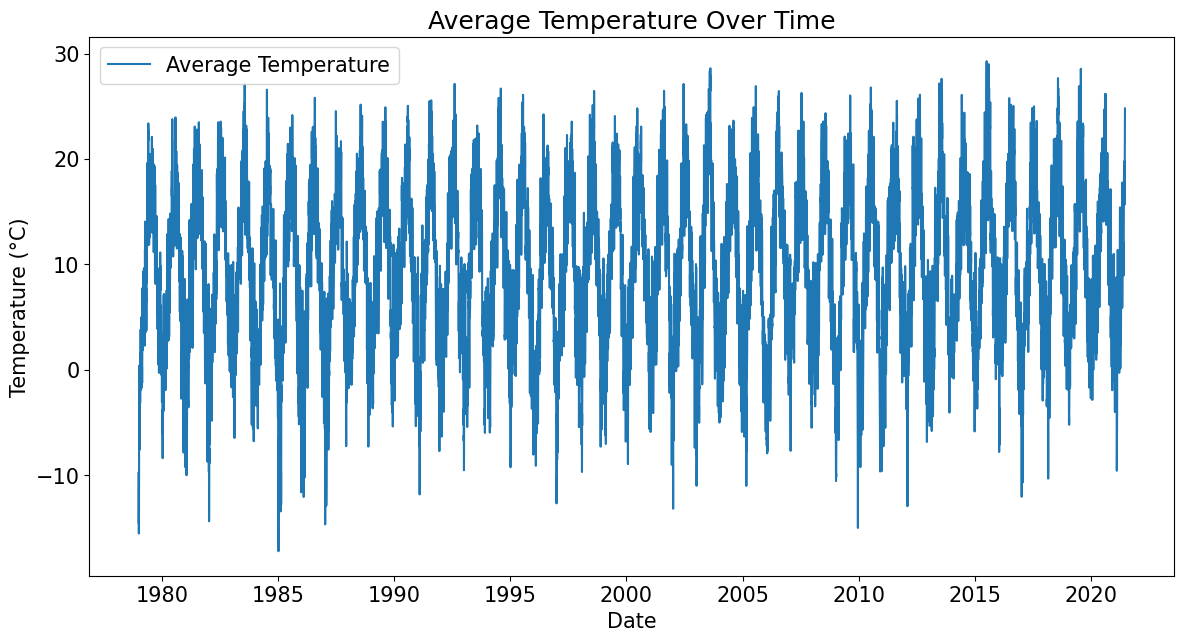

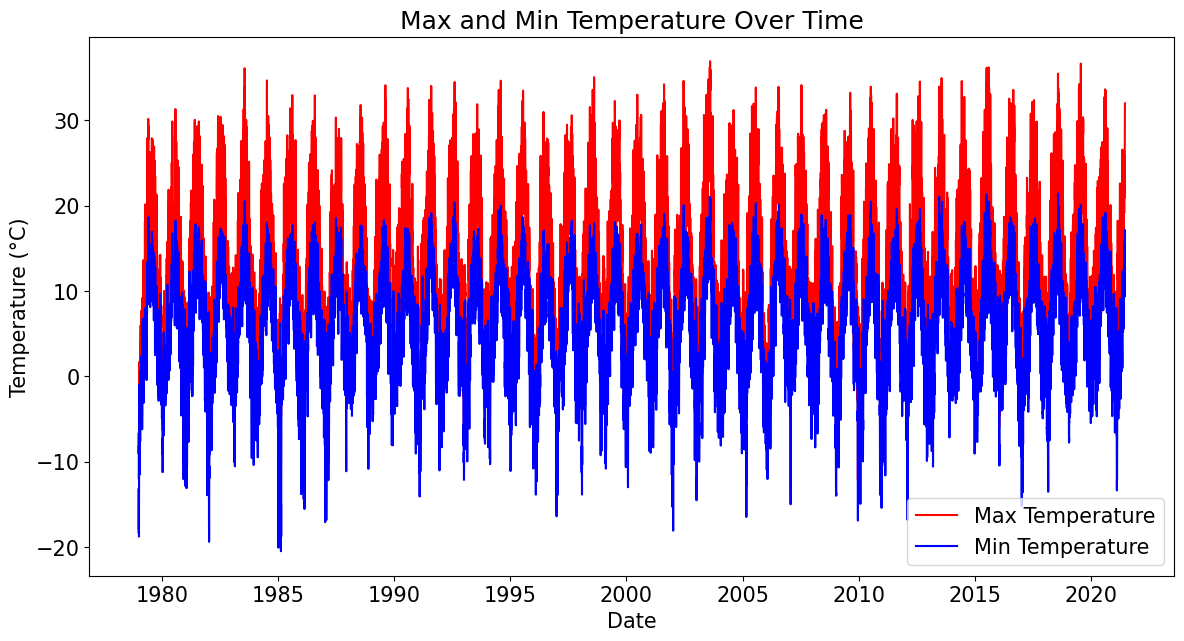

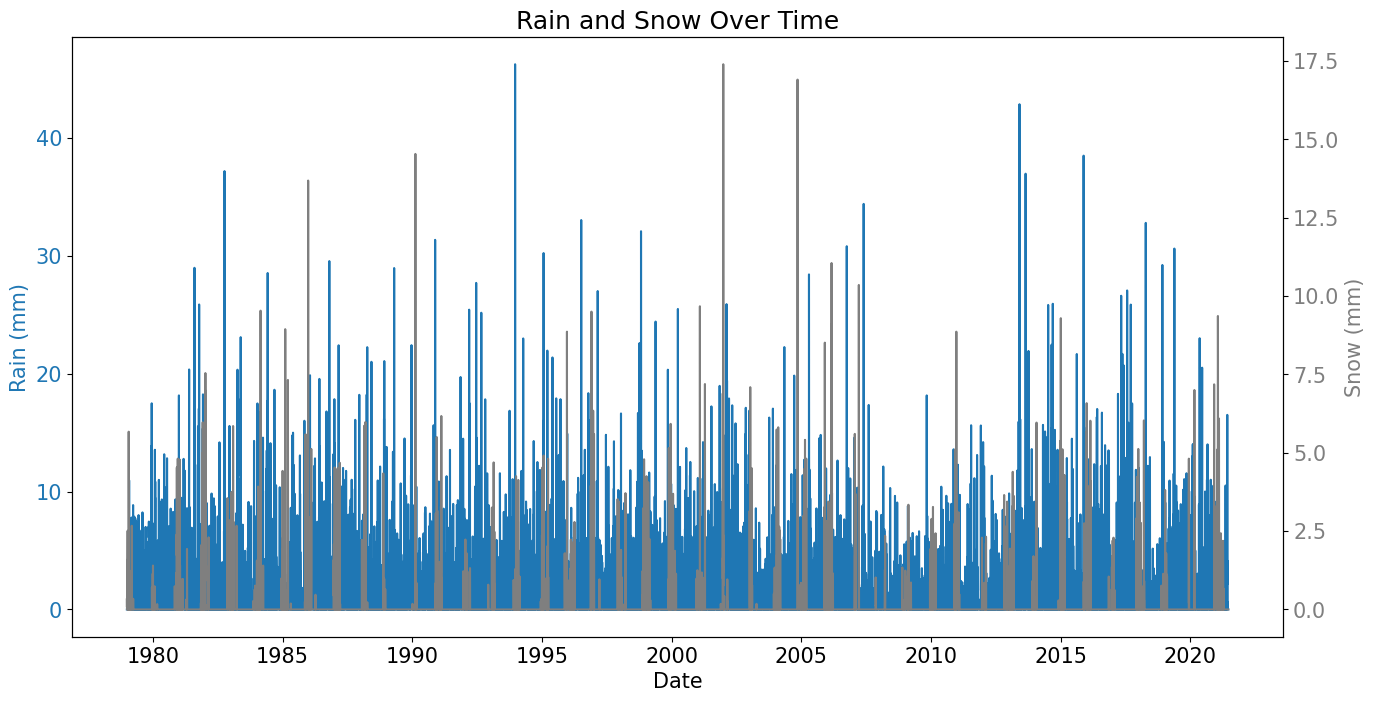

In [184]:
# Plotting the time series for average temperature
plt.figure(figsize=(14, 7))
plt.plot(weather_wue_df.index, weather_wue_df['temp_avg'], label='Average Temperature')
plt.title('Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plotting the time series for maximum and minimum temperature
plt.figure(figsize=(14, 7))
plt.plot(weather_wue_df.index, weather_wue_df['temp_max'], label='Max Temperature', color='red')
plt.plot(weather_wue_df.index, weather_wue_df['temp_min'], label='Min Temperature', color='blue')
plt.title('Max and Min Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plotting the time series for rain and snow
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Rain (mm)', color='tab:blue')
ax1.plot(weather_wue_df.index, weather_wue_df['rain'], label='Rain', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Snow (mm)', color='tab:gray')
ax2.plot(weather_wue_df.index, weather_wue_df['snow'], label='Snow', color='tab:gray')
ax2.tick_params(axis='y', labelcolor='tab:gray')

fig.tight_layout()
plt.title('Rain and Snow Over Time')
plt.show()

## Splitting the Dataset
To prepare for time series forecasting, we split our dataset into training and testing sets. The training set will be used to train our models, while the testing set will be used to evaluate the performance of these models. We have chosen January 1, 2013, as the cut-off date for this split. 
The dataset is divided as follows:
- **Training Set**: Data from January 1, 1979, to December 31, 2012.
- **Testing Set**: Data from January 1, 2013, onwards.

This split allows us to train our models on a substantial portion of the historical data and test their performance on more recent data. Below is the code that performs the split and verifies the number of rows in each set:


In [185]:
# Define the cutoff date for splitting the dataset
cutoff_date = '2013-01-01'

In [186]:
# Split the dataset into training and testing sets
train_df = weather_wue_df[weather_wue_df.index < cutoff_date]
test_df = weather_wue_df[weather_wue_df.index >= cutoff_date]

In [187]:
print("Training set summary:")
print(train_df.head())

Training set summary:
            temp_max  temp_min  temp_avg  rain  snow   
date                                                   
1979-01-01     -8.23    -17.83    -14.54   0.0  0.10  \
1979-01-02     -9.08    -14.35    -11.86   0.0  0.35   
1979-01-03     -6.65    -13.16     -9.72   0.0  0.00   
1979-01-04     -9.84    -17.65    -13.18   0.0  0.00   
1979-01-05    -12.06    -18.39    -15.56   0.0  0.00   

                                                 weather_desc  
date                                                           
1979-01-01           light snow,snow,broken clouds,few clouds  
1979-01-02  light snow,overcast clouds,mist,haze,broken cl...  
1979-01-03  broken clouds,mist,overcast clouds,scattered c...  
1979-01-04                 sky is clear,mist,scattered clouds  
1979-01-05                             mist,broken clouds,fog  


In [188]:
print("\nTesting set summary:")
print(test_df.head())


Testing set summary:
            temp_max  temp_min  temp_avg  rain  snow   
date                                                   
2013-01-01      6.93      2.21      4.99  0.00   0.0  \
2013-01-02      3.92      0.64      2.09  0.00   0.0   
2013-01-03      5.19      0.80      3.34  1.12   0.0   
2013-01-04      7.50      5.38      6.62  0.61   0.0   
2013-01-05      7.40      5.54      6.23  9.84   0.0   

                                                 weather_desc  
date                                                           
2013-01-01  sky is clear,scattered clouds,overcast clouds,...  
2013-01-02  overcast clouds,scattered clouds,sky is clear,...  
2013-01-03  broken clouds,scattered clouds,few clouds,over...  
2013-01-04  overcast clouds,light intensity drizzle rain,f...  
2013-01-05  overcast clouds,light intensity drizzle rain,m...  


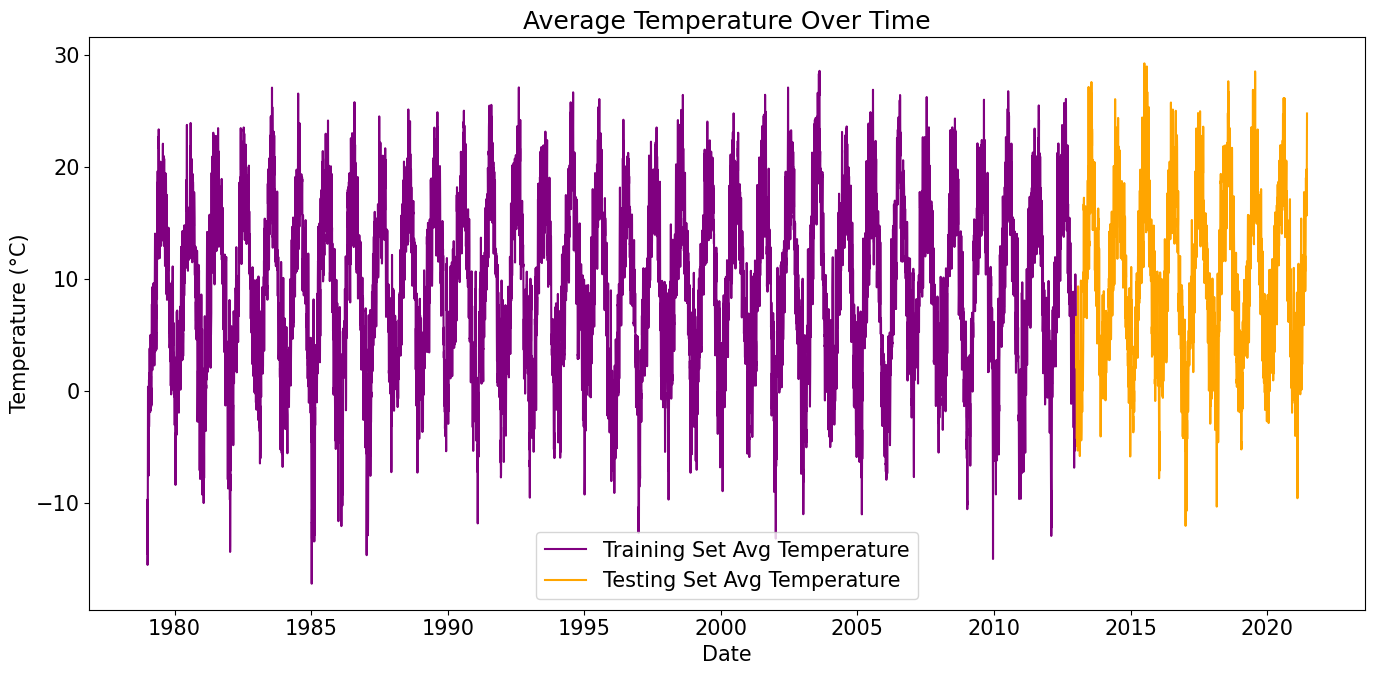

In [189]:
# Plotting the average temperature for training and testing sets

plt.figure(figsize=(14, 7))

# Plotting average temperature for the training set
plt.plot(train_df.index, train_df['temp_avg'], label='Training Set Avg Temperature', color='purple')

# Plotting average temperature for the testing set
plt.plot(test_df.index, test_df['temp_avg'], label='Testing Set Avg Temperature', color='orange')

# Adding title and labels
plt.title('Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.tight_layout()
plt.show()

## Time Series Prediction using LSTM

In this section, we will build and train an LSTM model to predict the average temperature using the historical weather data.

In [190]:
from sklearn.preprocessing import MinMaxScaler

### Data Preparation

We start by preparing our data. We will use a window size of 30 days to predict the next day's average temperature. The data is normalized using MinMaxScaler to ensure that all values are within the same range, which is beneficial for the training process of the neural network.

In [191]:

# We will use only the 'temp_avg' column for univariate prediction
train_data = train_df[['temp_avg']]
test_data = test_df[['temp_avg']]

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [192]:
# Convert the data into sequences
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

window_size = 5  # Adjust the window size as needed
X_train, y_train = df_to_X_y(pd.DataFrame(train_data), window_size)
X_test, y_test = df_to_X_y(pd.DataFrame(test_data), window_size)

### Model Architecture

The LSTM model consists of two LSTM layers followed by dense layers. The architecture is as follows:
- The first LSTM layer has 50 units and returns sequences, allowing the second LSTM layer to process the entire sequence.
- The second LSTM layer also has 50 units but does not return sequences.
- Two dense layers are used to produce the final output.

In [193]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
y_train

array([[-14.88],
       [-14.68],
       [ -8.92],
       ...,
       [  6.09],
       [  6.43],
       [  5.4 ]])

In [194]:
# Check the version to ensure it installed correctly
print(tf.__version__)

2.16.1


In [195]:
# Define the LSTM model
model = Sequential()
model.add(InputLayer((window_size, 1)))  # Explicit input layer
model.add(LSTM(50, return_sequences=True))  # First LSTM layer
model.add(LSTM(50))  # Second LSTM layer
model.add(Dense(25, activation='relu'))  # Intermediate dense layer with ReLU activation
model.add(Dense(1, activation='linear'))  # Output layer
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 5, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [196]:
from tensorflow.keras.callbacks import ModelCheckpoint

# set a checkpoint
checkpoint = ModelCheckpoint('model/model_checkpoint.keras', save_best_only=True)
# Compile the model
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

### Training the Model

We train the model using the training set, and validate it using the testing set. The model is compiled with the Adam optimizer and the mean squared error loss function.

In [197]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 107.3512 - root_mean_squared_error: 10.3048 - val_loss: 29.3774 - val_root_mean_squared_error: 5.4201
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 19.7738 - root_mean_squared_error: 4.4345 - val_loss: 10.9002 - val_root_mean_squared_error: 3.3015
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 9.4076 - root_mean_squared_error: 3.0649 - val_loss: 7.3519 - val_root_mean_squared_error: 2.7114
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 7.2226 - root_mean_squared_error: 2.6850 - val_loss: 5.8730 - val_root_mean_squared_error: 2.4234
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.7786 - root_mean_squared_error: 2.4035 - val_loss: 5.3288 - val_root_mean_squared_error: 2.3084
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.4552 - root_mean_squared_error: 2.3353 - val_loss: 5.0471 - val_root_mean_squared_error: 2.2466
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 21

In [198]:
from tensorflow.keras.models import load_model
from keras.layers import TFSMLayer

model = load_model('model/model_checkpoint.keras')


### Predictions

After training the model, we make predictions on both the training and testing sets. The predictions are then inverse transformed to the original scale for comparison with the actual values.

In [199]:
# Make predictions
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test)

388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [200]:
# Inverse transform the predictions
#train_predictions = scaler.inverse_transform(train_predictions)
#y_train = scaler.inverse_transform(y_train)
#test_predictions = scaler.inverse_transform(test_predictions)
#y_test = scaler.inverse_transform(y_test)
#train_predictions_flattened = train_predictions.flatten()
#y_train_flattened = y_train.flatten()

train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train.flatten()})
#y_train

In [201]:
train_results

,Train Predictions,Actuals
0,-8.742396,-14.88
1,-8.849239,-14.68
2,-8.936734,-8.92
3,-8.184780,-1.99
4,-5.398417,0.00
...,...,...
12409,6.215070,6.39
12410,6.892609,4.53
12411,4.443450,6.09
12412,6.970996,6.43


### Results

We plot the actual and predicted average temperatures for both the training and testing sets to visualize the model's performance.


In [202]:
# Plot the results
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

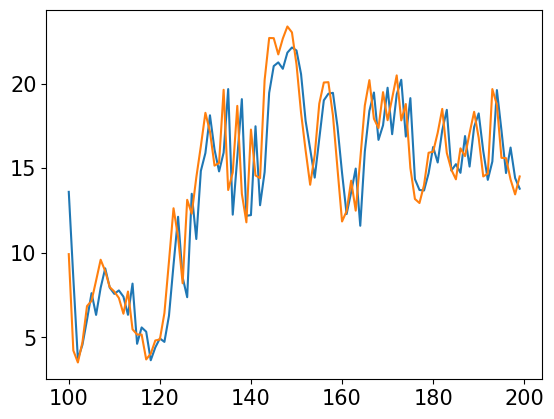

In [203]:
plt.plot(train_results['Train Predictions'][100:200])
plt.plot(train_results['Actuals'][100:200])

In [204]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test.flatten()})
test_results

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Test Predictions,Actuals
0,5.358093,5.45
1,4.751740,5.39
2,5.260953,3.42
3,3.180835,2.62
4,2.978931,1.44
...,...,...
3081,14.971823,17.60
3082,18.306581,20.59
3083,20.421587,22.37
3084,21.255905,23.97


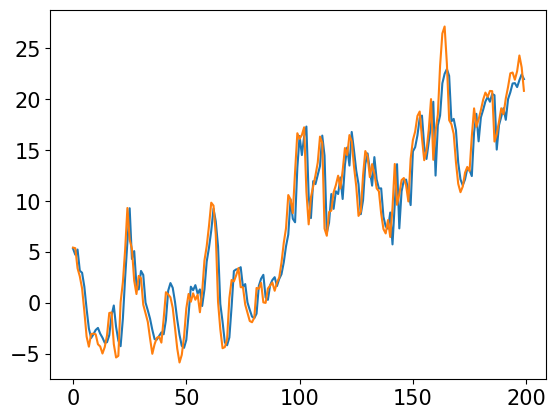

In [205]:
plt.plot(test_results['Test Predictions'][:200])
plt.plot(test_results['Actuals'][:200])

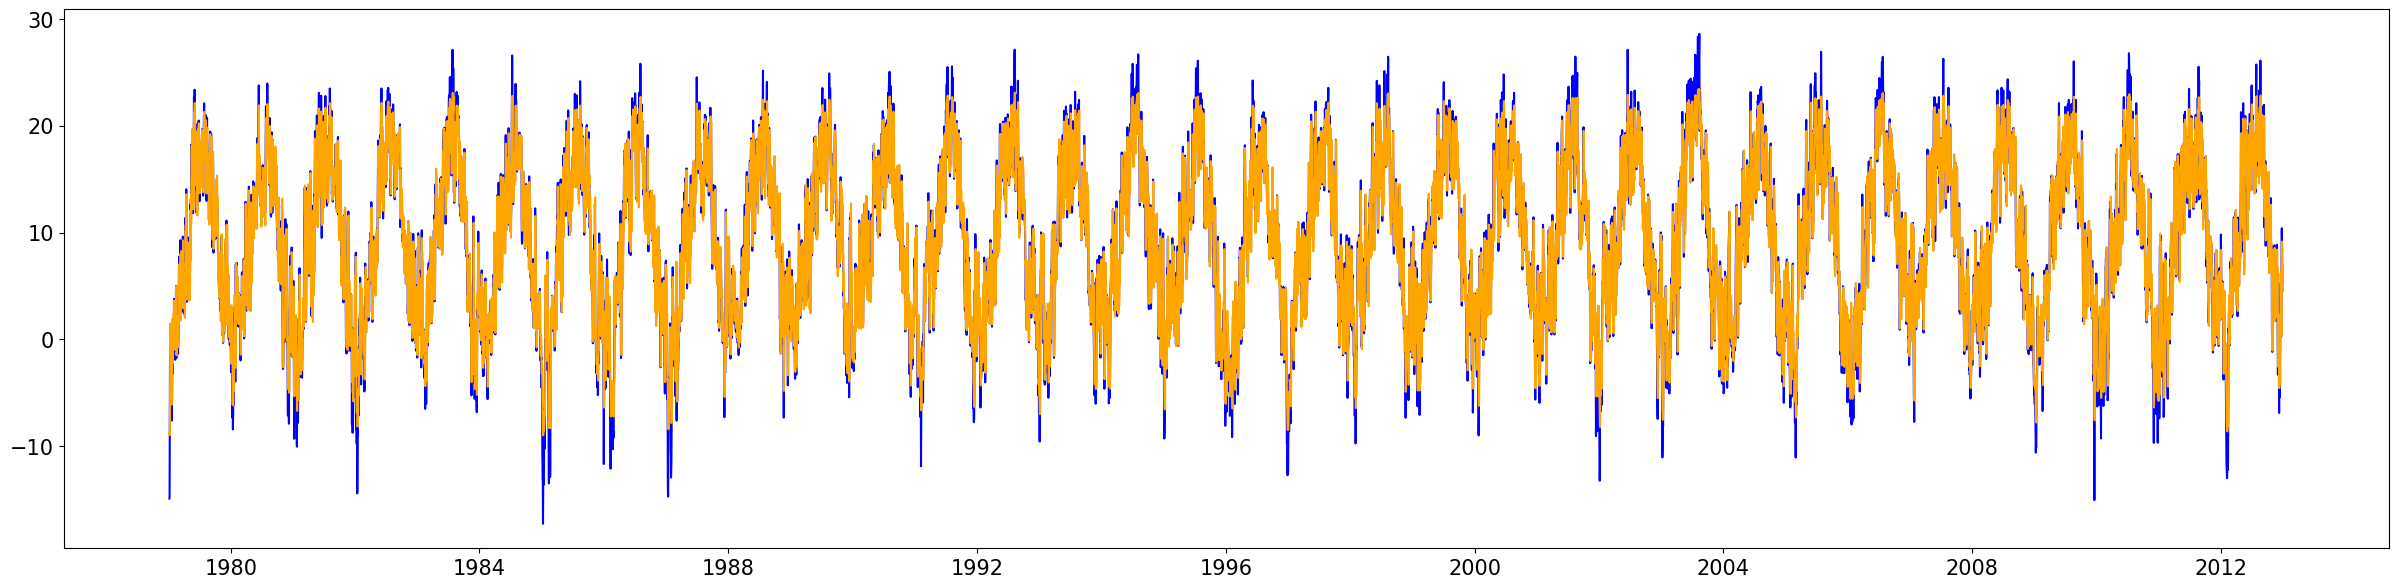

In [206]:
# Plot training data
plt.figure(figsize=(30, 7))
plt.plot(train_df.index[window_size:], y_train, label='Train Actual', color='blue')
plt.plot(train_df.index[window_size:], train_predictions, label='Train Predictions', color='orange')

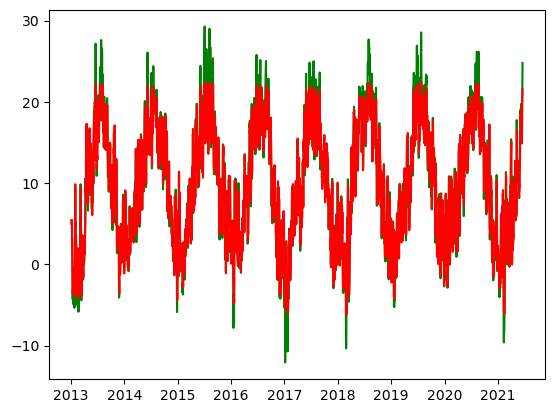

In [31]:
# Plot testing data
plt.plot(test_df.index[window_size:], y_test, label='Test Actual', color='green')
plt.plot(test_df.index[window_size:], test_predictions, label='Test Predictions', color='red')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


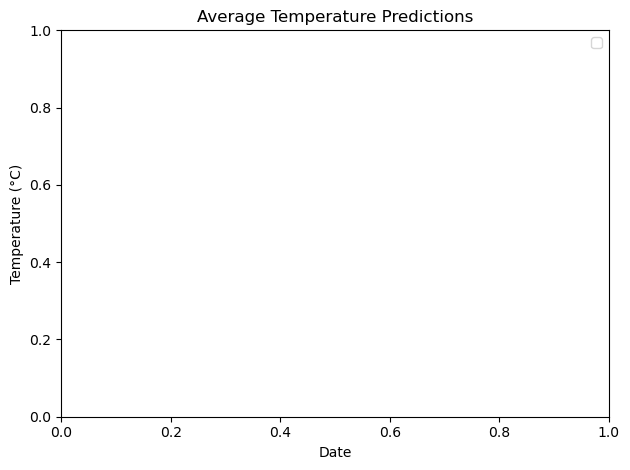

In [32]:
# Adding title and labels
plt.title('Average Temperature Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()

## Time Series Prediction using ARIMA
Now, we repeat the same process with using ARIMA (Auto Regression Integrated Moving Average) Model

### Loading the ARIMA Model



In [33]:
from pmdarima.arima import auto_arima


### Train the ARIMA model

In [34]:
## Instanciating the model
arima_model = auto_arima(train_df['temp_avg'], 
                         trace=True, 
                         error_action='ignore', 
                         suppress_warnings=True, 
                         seasonal=False)# Print the model summary
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=53275.019, Time=1.76 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=96818.708, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=54639.930, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=81922.945, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=53821.787, Time=1.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=54031.993, Time=1.55 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=53264.079, Time=1.47 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=53355.160, Time=2.48 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=53354.983, Time=6.32 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=53263.796, Time=3.72 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=53263.006, Time=2.93 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=53474.960, Time=1.55 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=53263.093, Time=4.03 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=53356.549, Time=2.24 sec
 ARIMA(3,0,4)(0,0,0

### Make Predictions with ARIMA 


In [35]:
# Forecasting on the test set
n_periods = len(test_df)
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Convert forecast to a dataframe
forecast_index = test_df.index
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

### Evaluation

#### Compute the mean squared error

In [36]:
mse = mean_squared_error(test_df['temp_avg'], forecast)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 55.73641280082164


### Conclusion

In [37]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

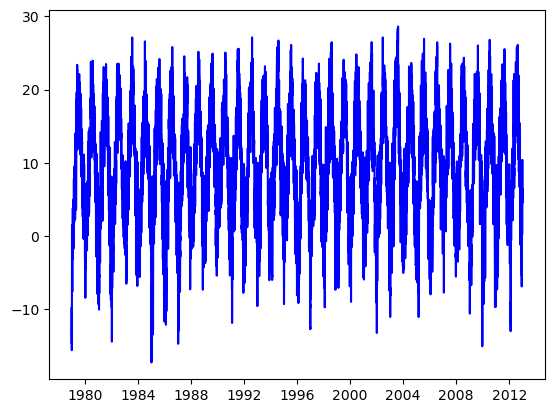

In [38]:
# Plot training data
plt.plot(train_df.index, train_df['temp_avg'], label='Train Actual', color='blue')

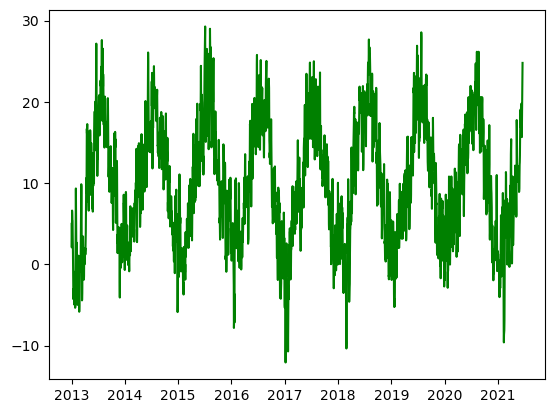

In [39]:
# Plot testing data
plt.plot(test_df.index, test_df['temp_avg'], label='Test Actual', color='green')

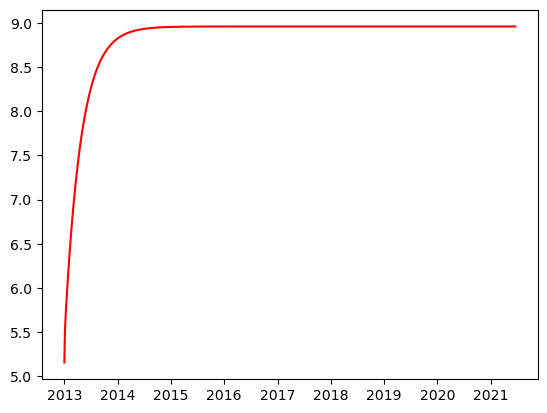

In [40]:
# Plot forecast data
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


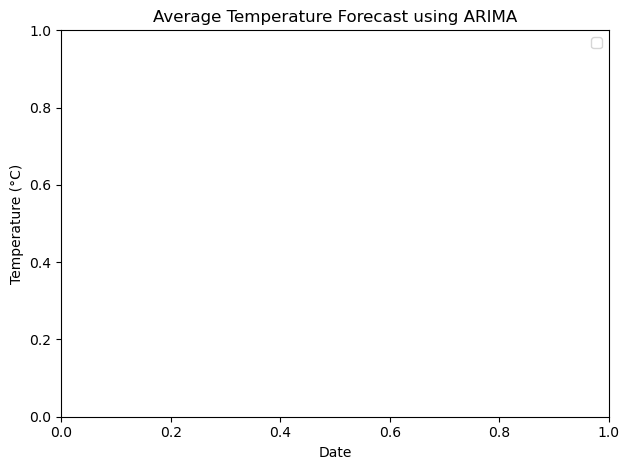

In [41]:
# Adding title and labels
plt.title('Average Temperature Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
#!git clone https://github.com/time-series-foundation-models/lag-llama/ lag-llama-new

## Time Series Prediction using LLag LLama
Now, we repeat the same process with using ARIMA (Auto Regression Integrated Moving Average) Model

In [43]:
cd lag-llama-new


C:\Users\AliAlpOezer\Desktop\Time Series Forecasting Papers &  relevant files\lag-llama-new


In [151]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

In [153]:
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


In [154]:
# Select the 'temp_avg' column for univariate time series prediction
data = weather_wue_df[['temp_avg']].values

# Split the data into training and testing sets
train_data_tensor, test_data_tensor = train_test_split(data, test_size=0.2, shuffle=False)

In [155]:
# Convert to PyTorch tensors
train_data_tensor = torch.tensor(train_data_tensor, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data_tensor, dtype=torch.float32)

In [156]:
# Create sequences of data for training and testing
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data[i:i+window_size]
        label = data[i+window_size]
        sequences.append((sequence, label))
    return sequences
window_size = 32
train_sequences = create_sequences(train_data_tensor, window_size)
test_sequences = create_sequences(test_data_tensor, window_size)

In [157]:
# Create a custom Dataset class for PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return sequence, label

In [158]:
# Create DataLoader instances for training and testing
train_dataset = TimeSeriesDataset(train_sequences)
test_dataset = TimeSeriesDataset(test_sequences)

In [161]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(test_dataset)

In [57]:
#!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/new-lag-llama

\content\new-lag-llama\lag-llama.ckpt


Download complete. Moving file to \content\new-lag-llama\lag-llama.ckpt


In [162]:
# Load the checkpoint and initialize the model
ckpt_path = 'C:/content/new-lag-llama/lag-llama.ckpt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [163]:
ckpt = torch.load(ckpt_path,  map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

In [164]:
# Load the checkpoint and initialize the model
estimator = LagLlamaEstimator(
        ckpt_path=ckpt_path,
        prediction_length=1,
        context_length=32,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=None,
        batch_size=32,
        num_parallel_samples=100,
        device=device
    )

In [165]:
lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

In [166]:
# Save the model to a specific directory
save_directory = "./lag-llama"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

AttributeError: 'Sequential' object has no attribute 'save_pretrained'

In [167]:
# Ensure that 'temp_avg' is a numerical column
weather_wue_df['temp_avg'] = pd.to_numeric(weather_wue_df['temp_avg'], errors='coerce')
from gluonts.dataset.common import ListDataset

# Drop rows with NaN values
weather_df_glu = weather_wue_df.dropna(subset=['temp_avg'])

# Extract the 'temp_avg' values
data = weather_df_glu['temp_avg'].values

# Split the data into training and testing sets
train_data_glu, test_data_glu = train_test_split(data, test_size=0.2, shuffle=False)

# Convert to ListDataset format expected by GluonTS
prediction_length = 1
freq = "1H"

train_dataset = ListDataset(
    [{'start': pd.Timestamp("1979-01-01"), 'target': x} for x in [train_data_glu]],
    freq=freq
)

test_dataset = ListDataset(
    [{'start': pd.Timestamp("1979-01-01"), 'target': x} for x in [test_data_glu]],
    freq=freq
)

C:\Users\AliAlpOezer\AppData\Local\Temp\ipykernel_30676\206486818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_wue_df['temp_avg'] = pd.to_numeric(weather_wue_df['temp_avg'], errors='coerce')


In [168]:
train_dataset

[{'start': Period('1979-01-01 00:00', 'H'),
  'target': array([-14.54, -11.86,  -9.72, ...,   3.84,   2.87,   0.25], dtype=float32)}]

In [108]:
# Make predictions on the test data using make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,
    predictor=predictor,
    num_samples=100
)

Running evaluation: 1it [00:00, 37.38it/s]


CRPS: 0.01982130885607815


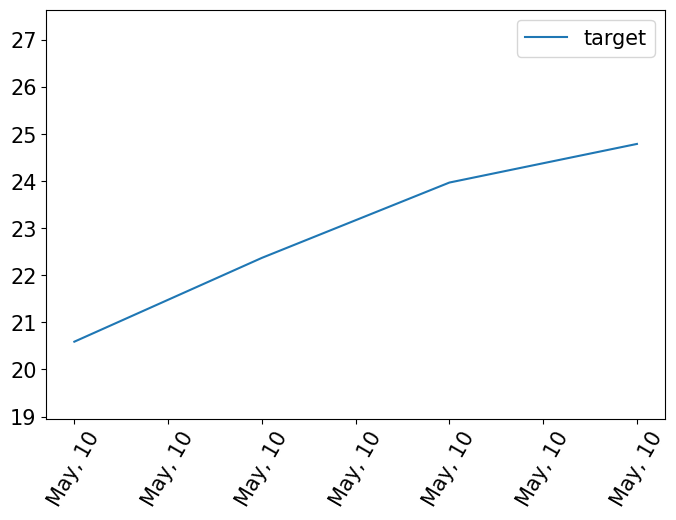

In [109]:
forecasts = list(forecast_it)
tss = list(ts_it)

# Evaluate the forecasts
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

# Plot the results
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [133]:
import pandas as pd

# Load the datasetpd.read_excel('historische-wetterdaten-kompakt-1979-2021.xlsx',
file_path = 'historische-wetterdaten-kompakt-1979-2021.xlsx'
df = pd.read_excel('C:/Users/AliAlpOezer/Desktop/Time Series Forecasting Papers &  relevant files/historische-wetterdaten-kompakt-1979-2021.xlsx', index_col=[0], parse_dates=[0])
# Display the first few rows of the dataset to understand its structure
df.head()


,temp_max,temp_min,temp_avg,rain,snow,weather_desc
date,,,,,,
1979-01-01,-8.23,-17.83,-14.54,0.0,0.10,"light snow,snow,broken clouds,few clouds"
1979-01-02,-9.08,-14.35,-11.86,0.0,0.35,"light snow,overcast clouds,mist,haze,broken cl..."
1979-01-03,-6.65,-13.16,-9.72,0.0,0.00,"broken clouds,mist,overcast clouds,scattered c..."
1979-01-04,-9.84,-17.65,-13.18,0.0,0.00,"sky is clear,mist,scattered clouds"
1979-01-05,-12.06,-18.39,-15.56,0.0,0.00,"mist,broken clouds,fog"


In [134]:
# Ensure that 'temp_avg' is a numerical column and handle missing values
df['temp_avg'] = pd.to_numeric(df['temp_avg'], errors='coerce')
df = df.dropna(subset=['temp_avg'])

# Extract the 'temp_avg' column
data = df['temp_avg'].values

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
import torch
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)

# Create sequences of data for training and testing
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data[i:i+window_size]
        label = data[i+window_size]
        sequences.append((sequence, label))
    return sequences

window_size = 32
train_sequences = create_sequences(train_data_tensor, window_size)
test_sequences = create_sequences(test_data_tensor, window_size)

# Create a custom Dataset class for PyTorch
from torch.utils.data import DataLoader, Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return sequence, label

# Create DataLoader instances for training and testing
train_dataset = TimeSeriesDataset(train_sequences)
test_dataset = TimeSeriesDataset(test_sequences)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [142]:
import torch
from lag_llama.gluon.estimator import LagLlamaEstimator

# Load the checkpoint and initialize the model
# Load the checkpoint and initialize the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load(ckpt_path,  map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
    ckpt_path=ckpt_path,
    prediction_length=1,
    context_length=32,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    rope_scaling=None,
    batch_size=32,
    num_parallel_samples=100,
    device=device
)

# Create the transformation and predictor
transformation = estimator.create_transformation()
lightning_module = estimator.create_lightning_module()
predictor = estimator.create_predictor(transformation, lightning_module)


Running evaluation: 1it [00:00, 16.71it/s]


CRPS: 0.019988440156308372


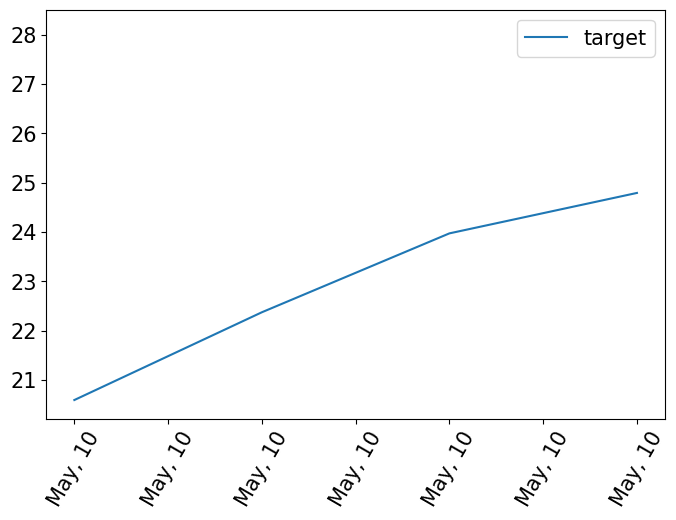

In [143]:
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator

# Convert the test data to the ListDataset format expected by GluonTS
test_dataset = ListDataset(
    [{'start': pd.Timestamp("1979-01-01"), 'target': test_data}],
    freq="1H"
)

# Make predictions on the test data using make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# Evaluate the forecasts
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

# Plot the results
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import islice

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()


In [144]:
test_dataset

[{'start': Period('1979-01-01 00:00', 'H'),
  'target': array([ 1.58,  4.62, 10.12, ..., 22.37, 23.97, 24.79], dtype=float32)}]

In [173]:
import pandas as pd

# Load the dataset
df = pd.read_excel('C:/Users/AliAlpOezer/Desktop/Time Series Forecasting Papers &  relevant files/historische-wetterdaten-kompakt-1979-2021.xlsx')

# Ensure 'temp_avg' is a numerical column and handle missing values
df['temp_avg'] = pd.to_numeric(df['temp_avg'], errors='coerce')
df = df.dropna(subset=['temp_avg'])

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Ensure the data covers the required date range from 1979-01-01 to 2013-01-01
start_date = '1979-01-01'
split_date = '2013-01-01'
df = df.loc[start_date:]

# Extract the 'temp_avg' column as a numpy array
data = df['temp_avg'].values
# Split the data into training and testing sets based on the split date
train_data = df.loc[:split_date, 'temp_avg'].values
test_data = df.loc[split_date:, 'temp_avg'].values

In [174]:
from gluonts.dataset.common import ListDataset

# Define the prediction length and frequency
prediction_length = 48  # 48 hours prediction
freq = 'H'



train_dataset = ListDataset(
    [{'start': pd.Timestamp(start_date), 'target': train_data}],
    freq=freq
)

test_dataset = ListDataset(
    [{'start': pd.Timestamp(split_date), 'target': test_data}],
    freq=freq
)

# Display the format of the datasets to verify
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)


Train Dataset: [{'start': Period('1979-01-01 00:00', 'H'), 'target': array([-14.54, -11.86,  -9.72, ...,   6.43,   5.4 ,   4.99], dtype=float32)}]
Test Dataset: [{'start': Period('2013-01-01 00:00', 'H'), 'target': array([ 4.99,  2.09,  3.34, ..., 22.37, 23.97, 24.79], dtype=float32)}]


Running evaluation: 1it [00:00, 28.06it/s]


CRPS: 0.3046509339282755


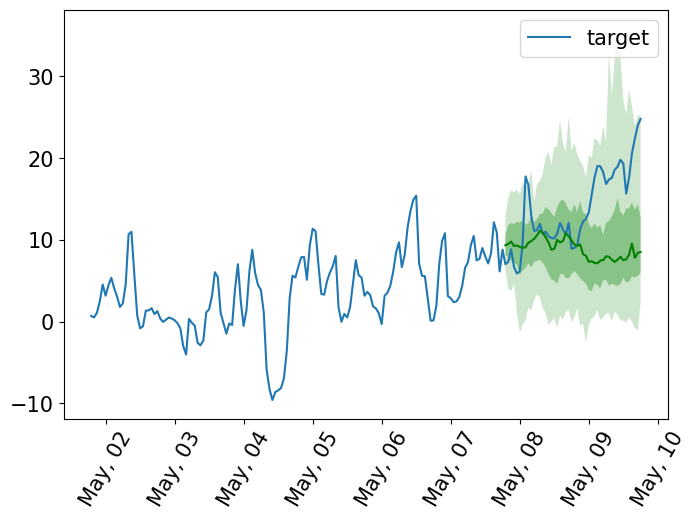

In [175]:
import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from lag_llama.gluon.estimator import LagLlamaEstimator

# Load the checkpoint and initialize the model
ckpt_path = '/content/new-lag-llama/lag-llama.ckpt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load(ckpt_path,  map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
    ckpt_path=ckpt_path,
    prediction_length=prediction_length,
    context_length=32,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    rope_scaling=None,
    batch_size=32,
    num_parallel_samples=100,
    device=device
)

# Create the transformation and predictor
transformation = estimator.create_transformation()
lightning_module = estimator.create_lightning_module()
predictor = estimator.create_predictor(transformation, lightning_module)

# Make predictions on the test data using make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# Evaluate the forecasts
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

# Plot the results
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import islice

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()
